# Titanic - Machine Learning from Disaster
---
## Introduction
This Kaggle's challenge is based on Titanic's shipwreck, which not everyone survived. The question proposed by the challenge, is: "**What sorts of people were more likely to survive?**", and to find it out, we can use passenger data (ie name, age, gender, socio-economic class, etc). 
The challenge also provides us two .csv files, the train and the test one. 
In order to solve this challenge, I decided to use **XGBoost**, as you can see below:  

---
## Importing the libraries

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from xgboost import XGBClassifier

---
## Loading databases, and data visualization 

In [2]:
titanic_train = pd.read_csv('titanic_train.csv') 
titanic_test = pd.read_csv('titanic_test.csv') 
titanic_train['train_test']=1
titanic_test['train_test']=0
titanic_test['Survived']=np.NaN
combined_data=pd.concat([titanic_train,titanic_test])
combined_data.describe() 
combined_data.head() 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [3]:
# Size
combined_data.shape

(1309, 13)

---
## Data preprocessing

In [4]:
# Missing values
combined_data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
train_test        0
dtype: int64

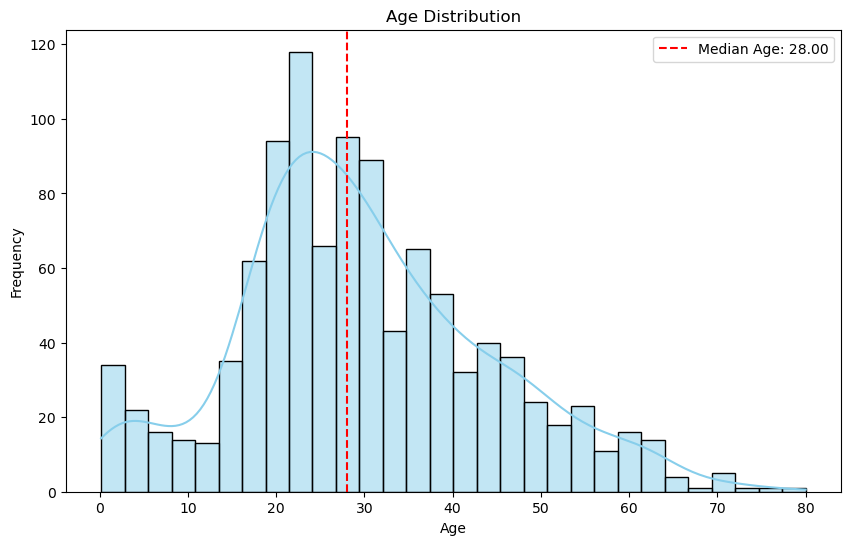

In [5]:
# Defining the chart size
plt.figure(figsize=(10, 6))

# Creating a histogram for 'Age'
sns.histplot(combined_data['Age'].dropna(), bins=30, kde=True, color='skyblue', edgecolor='black')

# Calculating the median age, for the chart
median = combined_data['Age'].median()
plt.axvline(median, color='red', linestyle='--', label=f'Median Age: {median:.2f}')

# Title and subtitle
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()

plt.show()

- **Cabin**: 1014/1309 rows don't have the Cabin's data, then, it's not safe to use this column in the analysis. 
- **Embarked**: only two  rows with null values. Then, to fill in missing values, as it's a categorical variable, I'll use the mode.
- **Age**: As seen in the chart above, most of the passengers are between 20 and 30 years old, then it seems plausible to fill in the missing values with the median. 

### Embarked

In [6]:
# Fiding the mode
mode = combined_data['Embarked'].mode()
mode[0]

'S'

In [7]:
# Filling missing values with the mode 
combined_data['Embarked'].fillna(mode[0], inplace=True)

# Checking missing values 
combined_data['Embarked'].isnull().sum()

0

### Age

In [8]:
# Filling missing values with the median 
combined_data['Age'].fillna(median, inplace=True)

# Checking missing values 
combined_data['Age'].isnull().sum()

0

### Title 
As seen in the column "Name", there's also the passenger's title, which might be interesting for the analysis. 

In [9]:
# Extracting the title of the 'Name' column 
combined_data['Title'] = combined_data['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())

# Checking the first lines 
combined_data[['Name', 'Title']].head()

,Name,Title
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,"Heikkinen, Miss. Laina",Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,"Allen, Mr. William Henry",Mr


In [10]:
# Checking missing values 
combined_data['Title'].isnull().sum()

0

## Exploratory analysis

In [11]:
# Creating dataframes with the Title column
titanic_train = combined_data[combined_data['train_test'] == 1]
titanic_test = combined_data[combined_data['train_test'] == 0]

titanic_train.head()
titanic_test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test,Title
0,892,NaN,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,Mr
1,893,NaN,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,Mrs
2,894,NaN,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,Mr
3,895,NaN,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,Mr
4,896,NaN,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,Mrs


In [12]:
# Columns for analysis
combined_data_2 = combined_data[['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'train_test']]
titanic_train_2 = titanic_train[['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'train_test']]

titanic_train_2.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,train_test
0,1,0.0,3,male,22.0,1,0,7.2500,S,Mr,1
1,2,1.0,1,female,38.0,1,0,71.2833,C,Mrs,1
2,3,1.0,3,female,26.0,0,0,7.9250,S,Miss,1
3,4,1.0,1,female,35.0,1,0,53.1000,S,Mrs,1
4,5,0.0,3,male,35.0,0,0,8.0500,S,Mr,1


### Categorical variables

<Axes: xlabel='Survived', ylabel='count'>

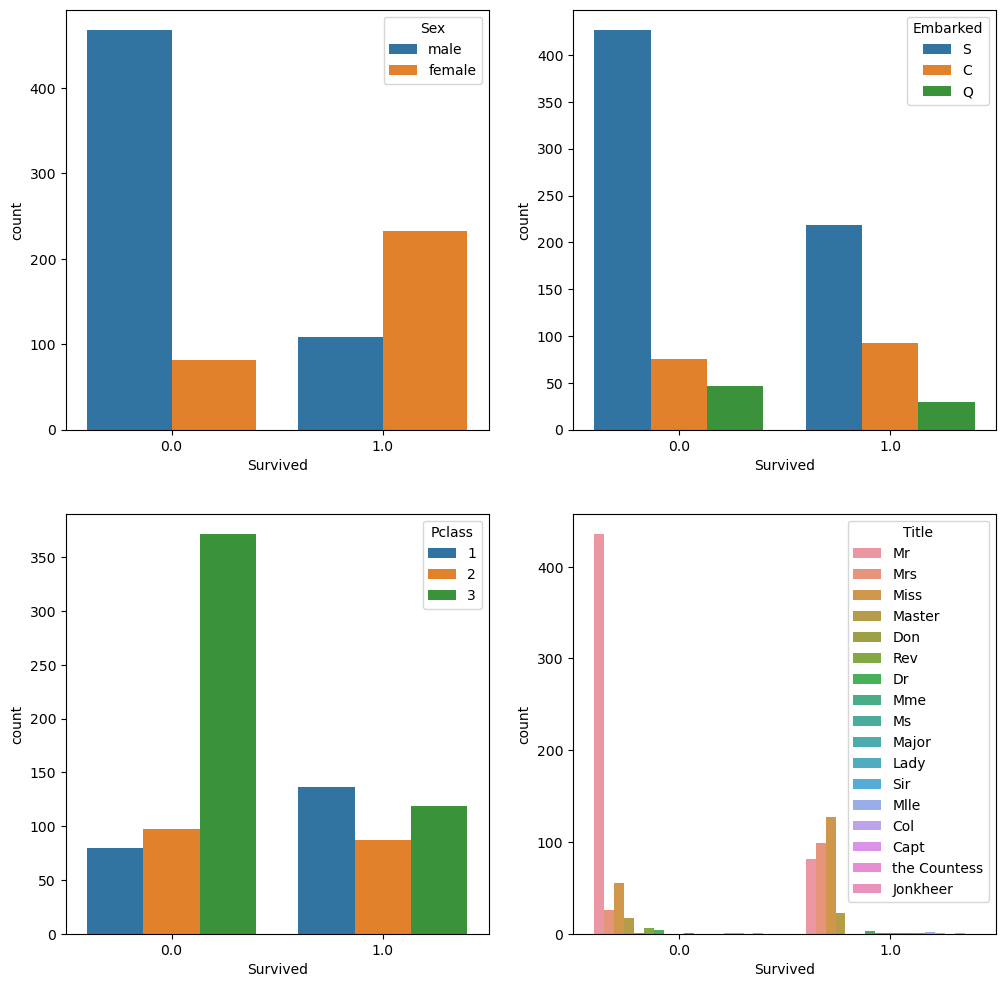

In [13]:
# Checking relation between categorical variables and survival 
fig, axis=plt.subplots(2,2, figsize=(12,12))
sns.countplot(x='Survived', data= titanic_train_2, hue='Sex', ax=axis[0,0])
sns.countplot(x='Survived', data= titanic_train_2, hue='Embarked', ax=axis[0,1])
sns.countplot(x='Survived', data= titanic_train_2, hue='Pclass', ax=axis[1,0]) 
sns.countplot(x='Survived', data= titanic_train_2, hue='Title', ax=axis[1,1]) 

Based on the visualization above, it's possible to realize that there's a relation between the categorical variables and the people who didn't survived, as following: 
- **Sex**: most passengers who didn't survived were male
- **Embarked**: most passengers who didn't survived embarked on Southampton (*the port of embarkation could also be C, for Cherbourg, or Q, for Queenstown*)
- **Pclass**: most passengers who didn't survived had the Class 3 ticket. Probably means that classes 1 and 2 had some kind of advantage to the saving boats 
- **Title**: most passengers who didn't survived were called "Mr". It makes sense with the first chart, as most of them were also male.

### Continuous variables

The continuous variables are: 
- **Age**: how old the passenger is
- **SibSp**: how many siblings/spouses were aboard
- **Parch**: how many parents/children were aboard
- **Fare**: passenger fare

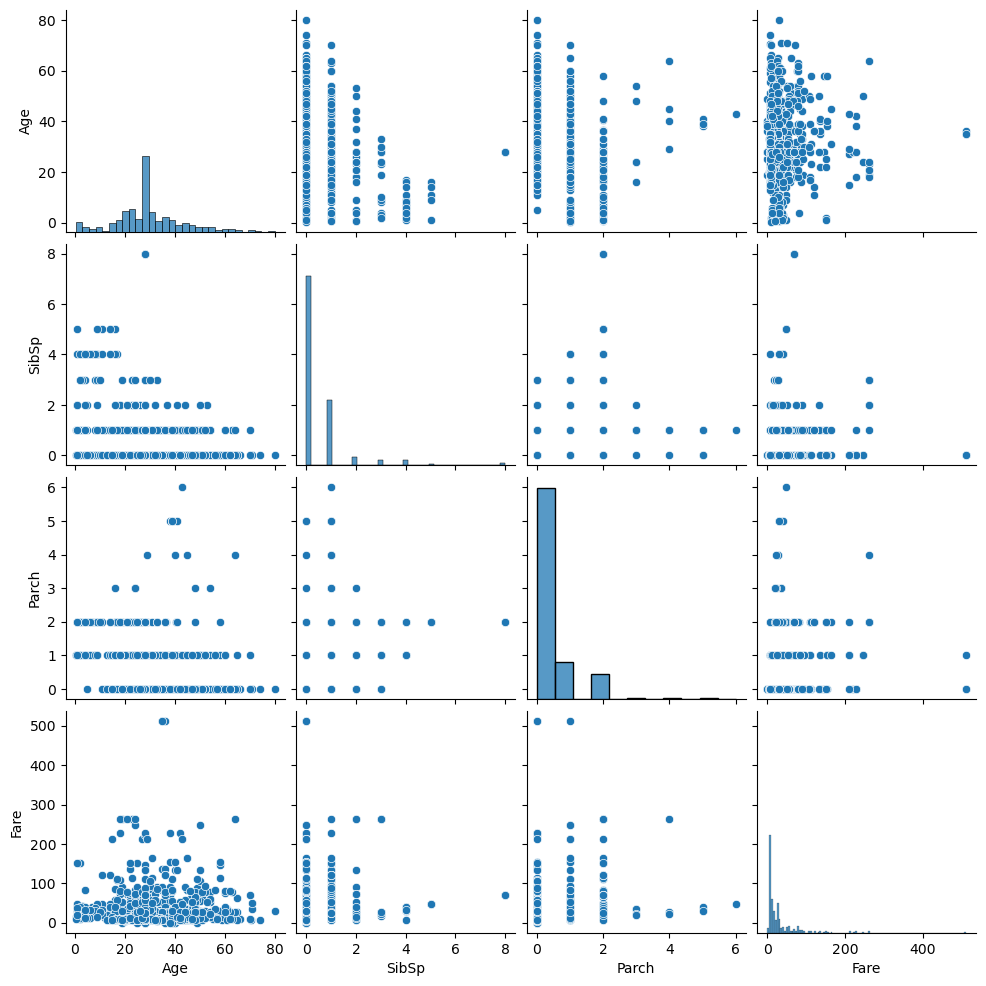

In [14]:
sns.pairplot(data=titanic_train_2[['Age','SibSp', 'Parch', 'Fare']]) 

Based on the charts above, there isn't a strong relation between the continuous variables. I'll also check with a heatmap: 

            Age     SibSp     Parch      Fare
Age    1.000000 -0.233296 -0.172482  0.096688
SibSp -0.233296  1.000000  0.414838  0.159651
Parch -0.172482  0.414838  1.000000  0.216225
Fare   0.096688  0.159651  0.216225  1.000000


<Axes: >

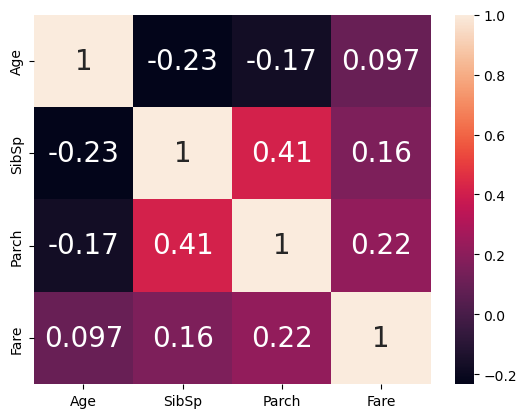

In [15]:
print(titanic_train_2[['Age','SibSp', 'Parch', 'Fare']].corr())
sns.heatmap(titanic_train_2[['Age','SibSp', 'Parch', 'Fare']].corr(), annot=True, annot_kws={'size':20})

Same result for the heatmap. Trying with the mean values: 

In [16]:
pd.pivot_table(titanic_train_2, index='Survived', values=['Age','SibSp', 'Parch', 'Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0.0,30.028233,22.117887,0.329690,0.553734
1.0,28.291433,48.395408,0.464912,0.473684


Seems like the mean values for the continuous variables are different, specially the Fare. Makes sense that the higher the fare, higher will be the chances of survival, as noticed by the previous class analysis

---
# XGBoost Modeling

## Preparing the dataframes

In [19]:
dummies = pd.get_dummies(combined_data_2[['PassengerId', 'Pclass','Sex','SibSp','Parch','Fare','Embarked', 'Title',
                                          'train_test']])

In [20]:
dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PassengerId         1309 non-null   int64  
 1   Pclass              1309 non-null   int64  
 2   SibSp               1309 non-null   int64  
 3   Parch               1309 non-null   int64  
 4   Fare                1308 non-null   float64
 5   train_test          1309 non-null   int64  
 6   Sex_female          1309 non-null   uint8  
 7   Sex_male            1309 non-null   uint8  
 8   Embarked_C          1309 non-null   uint8  
 9   Embarked_Q          1309 non-null   uint8  
 10  Embarked_S          1309 non-null   uint8  
 11  Title_Capt          1309 non-null   uint8  
 12  Title_Col           1309 non-null   uint8  
 13  Title_Don           1309 non-null   uint8  
 14  Title_Dona          1309 non-null   uint8  
 15  Title_Dr            1309 non-null   uint8  
 16  Title_J

In [21]:
X = dummies[dummies.train_test == 1].drop(['train_test'], axis =1)
y = combined_data.loc[combined_data['train_test'] == 1, ['Survived']]

Even though the challenge provides a train and test file, the test file doesn't have information about the passenger's survival, then I'll use only the train data to both train and validate the model.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = .3,
                                                    random_state = 5,
                                                   stratify = y)

## Modeling

In [23]:
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False)

In [24]:
param_grid = {
    'max_depth': [3,5,7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

### Configuration of Cross Validation and Grid Search

In [25]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(xgb_model, param_grid, scoring='roc_auc', n_jobs=-1, cv=kfold)
grid_search.fit(X_train, y_train)

C:\Users\William\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [18:26:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importanc...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='roc_auc')

### Results

In [26]:
print('Best Parameters:', grid_search.best_params_)
print('Best Score ROC-AUC:', grid_search.best_score_)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
Best Score ROC-AUC: 0.8747550316191832


### Avaliation of test group


In [27]:
y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:,1]
print('Test Accuracy:', accuracy_score(y_test, y_pred))
print('Test ROC-AUC:', roc_auc_score(y_test, y_pred_proba))
print('Test F1-Score:', f1_score(y_test, y_pred))

Test Accuracy: 0.832089552238806
Test ROC-AUC: 0.8707561047366872
Test F1-Score: 0.7486033519553074


## Applying the model

In [28]:
X_test_new = dummies[dummies.train_test == 0].drop(['train_test'], axis =1)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_new)

y_pred_proba = best_model.predict_proba(X_test_new)[:, 1]

Applying the model with the challenge's test file, with the best estimators found in the previous step. 

## Exporting the result

The challenge is to create a .csv file, with two columns, **PassengerId** and **Survived**, after applying the model.

In [29]:
result = pd.concat([titanic_test.PassengerId, pd.DataFrame(y_pred)], axis = 'columns')
result.columns = ["PassengerId", "Survived"]
result.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [30]:
result.to_csv('titanic_result.csv', header = True, index = False)
